<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.torch_imports import *
from fastai.dataset import *
from fastai.learner import *
from fastai.structured import *
from fastai.column_data import *
import feather

In [3]:
PATH = 'data/elo/'

In [4]:
dep = 'target'
df_raw = feather.read_dataframe('train_df')

In [5]:
df_test = feather.read_dataframe('test_df')

In [6]:
# df_raw.drop('outliers', axis=1, inplace=True)

In [7]:
df_indep = df_raw.drop(dep,axis=1)
n_valid = 12000
n_trn = len(df_raw)-n_valid

In [8]:
cat_flds = [n for n in df_indep.columns if df_raw[n].nunique()<50 and n != 'outliers']
' '.join(cat_flds)

'feature_1 feature_2 feature_3 first_active_monthYear first_active_monthMonth first_active_monthWeek first_active_monthDay first_active_monthDayofweek first_active_monthDayofyear first_active_monthIs_month_end first_active_monthIs_month_start first_active_monthIs_quarter_end first_active_monthIs_quarter_start first_active_monthIs_year_end first_active_monthIs_year_start city_id_nunique merchant_category_id_nunique state_id_nunique subsector_id_nunique purchase_Year_nunique purchase_Month_nunique purchase_Week_nunique purchase_Day_nunique installments_max installments_min month_lag_max month_lag_min authorized_flag_mean purchased_on_weekend_sum category_1_sum state_id_nunique_old subsector_id_nunique_old purchase_Year_nunique_old purchase_Month_nunique_old purchase_Day_nunique_old installments_max_old installments_min_old month_lag_max_old month_lag_min_old'

In [9]:
len(cat_flds)

39

In [10]:
[n for n in df_indep.drop(cat_flds,axis=1).columns if not is_numeric_dtype(df_raw[n])]

['first_active_month',
 'card_id',
 'purchase_date_max',
 'purchase_date_min',
 'purchase_date_max_old',
 'purchase_date_min_old']

In [11]:
for df in [df_raw, df_indep, df_test]:
    for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
                     'purchase_date_min_old', 'first_active_month']:
        df[f] = df[f].astype(np.int64) * 1e-9

In [12]:
[n for n in df_indep.drop(cat_flds,axis=1).columns if not is_numeric_dtype(df_raw[n])]

['card_id']

In [13]:
df_indep.drop('card_id', axis=1, inplace=True)
df_test.drop('card_id', axis=1, inplace=True)

In [14]:
for n in cat_flds: df_raw[n] = df_raw[n].astype('category').cat.as_ordered()

cont_flds = [n for n in df_indep.columns if n not in cat_flds and n!= 'outliers']
' '.join(cont_flds)

'first_active_month first_active_monthElapsed transactions_count merchant_id_nunique purchase_amount_sum purchase_amount_max purchase_amount_min purchase_amount_mean purchase_amount_var installments_sum installments_mean installments_var purchase_date_max purchase_date_min month_lag_mean month_lag_var month_diff_mean month_diff_std month_diff_var authorized_flag_sum purchased_on_weekend_mean category_1_mean card_id_size category_2_mean_mean category_2_sum_sum category_3_mean_mean category_3_sum_sum purchase_date_diff purchase_date_average purchase_date_uptonow inverse_avg_transactions_per_day days_since_last_transaction repurchase_merchant_rate merchant_category_repurchase avg_spend_per_merchant avg_trans_per_merchant avg_spend_per_transaction transactions_count_old city_id_nunique_old merchant_category_id_nunique_old merchant_id_nunique_old purchase_Week_nunique_old purchase_amount_sum_old purchase_amount_max_old purchase_amount_min_old purchase_amount_mean_old purchase_amount_var_old

In [15]:
df_raw = df_raw[cat_flds+cont_flds+[dep]]
df, y, nas, mapper = proc_df(df_raw, 'target', do_scale=True)

val_idx = list(range(n_trn, len(df)))

In [16]:
df_t, _, nas, mapper = proc_df(df_test, do_scale=True, mapper=mapper)

In [17]:
df.shape, df_t.shape

((201917, 160), (123623, 183))

In [18]:
apply_cats(df_t, df)

In [19]:
df_t = df_t[df.columns.values]

In [20]:
df_t.shape, df.shape

((123623, 160), (201917, 160))

In [21]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_flds, bs=64, test_df=df_t)

In [22]:
# df.head().T

In [23]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [24]:
emb_c = {n: len(c.cat.categories)+1 for n,c in df_raw[cat_flds].items()}
emb_c

{'feature_1': 6,
 'feature_2': 4,
 'feature_3': 3,
 'first_active_monthYear': 9,
 'first_active_monthMonth': 13,
 'first_active_monthWeek': 22,
 'first_active_monthDay': 2,
 'first_active_monthDayofweek': 8,
 'first_active_monthDayofyear': 23,
 'first_active_monthIs_month_end': 2,
 'first_active_monthIs_month_start': 2,
 'first_active_monthIs_quarter_end': 2,
 'first_active_monthIs_quarter_start': 3,
 'first_active_monthIs_year_end': 2,
 'first_active_monthIs_year_start': 3,
 'city_id_nunique': 27,
 'merchant_category_id_nunique': 40,
 'state_id_nunique': 14,
 'subsector_id_nunique': 25,
 'purchase_Year_nunique': 3,
 'purchase_Month_nunique': 3,
 'purchase_Week_nunique': 11,
 'purchase_Day_nunique': 31,
 'installments_max': 16,
 'installments_min': 15,
 'month_lag_max': 3,
 'month_lag_min': 3,
 'authorized_flag_mean': 2,
 'purchased_on_weekend_sum': 40,
 'category_1_sum': 17,
 'state_id_nunique_old': 21,
 'subsector_id_nunique_old': 35,
 'purchase_Year_nunique_old': 3,
 'purchase_Month

In [25]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]
metrics=[rmse]

In [26]:
y_range=(np.min(y)*1.2,np.max(y)*1.2)

In [27]:
emb_szs

[(6, 3),
 (4, 2),
 (3, 2),
 (9, 5),
 (13, 7),
 (22, 11),
 (2, 1),
 (8, 4),
 (23, 12),
 (2, 1),
 (2, 1),
 (2, 1),
 (3, 2),
 (2, 1),
 (3, 2),
 (27, 14),
 (40, 20),
 (14, 7),
 (25, 13),
 (3, 2),
 (3, 2),
 (11, 6),
 (31, 16),
 (16, 8),
 (15, 8),
 (3, 2),
 (3, 2),
 (2, 1),
 (40, 20),
 (17, 9),
 (21, 11),
 (35, 18),
 (3, 2),
 (12, 6),
 (32, 16),
 (15, 8),
 (11, 6),
 (13, 7),
 (14, 7)]

In [28]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_flds),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 3]),
                           ('trainable', True),
                           ('nb_params', 18)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 8)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 6)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 5]),
                           ('trainable', True),
                           ('nb_params', 45)])),
             ('Embedding-5',
              OrderedDict([('input_shape', [-1]),
   

In [29]:
# m = md.get_learner(emb_szs, len(cont_flds), 0.05, 1, [500,250], [0.5,0.05],
#                    y_range=y_range, use_bn=True)

In [30]:
len(cat_flds)

39

In [31]:
len(cont_flds)

84

In [32]:
m.lr_find()

 60%|█████▉    | 1779/2968 [00:08<00:05, 205.01it/s, loss=20.8]


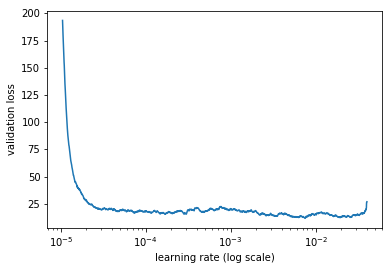

In [33]:
m.sched.plot()

In [49]:
lr=1e-4; wd=1e-8

In [35]:
%time m.fit(lr, 2, wd, cycle_len=1, cycle_mult=2, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                          
    0      14.116358  15.301947  3.730261  
    1      12.564603  14.78238   3.649593                      
    2      14.071389  14.413373  3.610268                      

CPU times: user 47.5 s, sys: 946 ms, total: 48.4 s
Wall time: 47.6 s


[array([14.41337]), 3.6102677050001044]

In [46]:
%time m.fit(lr, 3, wd, cycle_len=2, cycle_mult=2, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                          
    0      10.157521  14.36652   3.703269  
    1      9.729234   14.603302  3.734785                      
    2      8.299987   14.614522  3.738468                      
    3      9.467094   14.751621  3.750638                      
    4      8.08236    14.954849  3.783549                      
    5      7.299788   15.142056  3.807528                      
    6      6.656041   15.094102  3.80187                       

CPU times: user 53.2 s, sys: 1.04 s, total: 54.2 s
Wall time: 53 s


[array([15.0941]), 3.8018699405431136]

In [36]:
from sklearn.model_selection import StratifiedKFold

In [37]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_raw))
predictions = np.zeros(len(df_test))

In [38]:
outliers = df_indep['outliers']

In [39]:
target = df_raw['target']

In [40]:
val_idx[:5]

[189917, 189918, 189919, 189920, 189921]

1. Get the val_idx
2. Get the model data set 
`ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_flds, bs=64)`
3. Get the learner from model `md.get_learner(`
4. Fit the model `m.fit`

In [50]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df, outliers.values)):
    print("fold {}".format(fold_))
    md = ColumnarModelData.from_data_frame(PATH, val_idx, df, target.astype(np.float32), 
                                           cat_flds=cat_flds, bs=128, test_df=df_t)
    m = md.get_learner(emb_szs, len(df.columns)-len(cat_flds),
                   0.1, 1, [1000,500], [0.1,0.2], y_range=y_range)
    m.fit(lr, 3, wd, cycle_len=2, cycle_mult=2, metrics=[rmse])
    oof[val_idx] = m.predict().reshape(1, -1)[0]
#     predictions += m.predict(is_test=True) / folds.n_splits

rmse(oof, target)

fold 0


epoch      trn_loss   val_loss   rmse                          
    0      15.90532   14.590436  3.730362  
    1      16.636636  14.521373  3.723079                      
    2      14.094885  14.287253  3.691638                      
    3      15.200652  14.473827  3.726571                      
    4      13.269479  13.989985  3.654138                      
    5      14.168423  14.049192  3.6646                        
    6      14.935375  13.990876  3.657652                      
    7      15.293805  14.116217  3.679225                      
    8      14.136285  14.037943  3.664146                      
    9      15.499863  13.766563  3.631436                      
    10     12.939522  13.711981  3.618812                      
    11     12.937443  13.63897   3.608274                      
    12     12.376907  13.645307  3.611287                      
    13     12.040647  13.648799  3.611737                      

fold 1


epoch      trn_loss   val_loss   rmse                          
    0      19.169962  14.847157  3.772192  
    1      15.924142  14.515021  3.725014                      
    2      14.702569  14.379131  3.706228                      
    3      12.261706  14.182392  3.681849                      
    4      13.598058  14.034147  3.665217                      
    5      13.969396  13.991572  3.657983                      
    6      14.463711  13.808887  3.630376                      
    7      12.045211  13.826998  3.633127                      
    8      14.481098  13.875959  3.645563                      
    9      13.372849  13.666987  3.614234                      
    10     14.334264  13.624824  3.606543                      
    11     13.514668  13.661471  3.614602                      
    12     12.351634  13.65184   3.613192                      
    13     12.021324  13.665567  3.615174                      

fold 2


epoch      trn_loss   val_loss   rmse                          
    0      15.553468  14.57795   3.726842  
    1      13.320078  14.381167  3.698273                      
    2      13.914944  14.187339  3.671701                      
    3      15.009974  14.003612  3.650309                      
    4      13.781466  13.74567   3.605476                      
    5      13.03731   13.771313  3.61168                       
    6      12.017088  13.770312  3.606614                      
    7      12.378191  13.730836  3.599832                      
    8      12.774747  13.62501   3.585738                      
    9      12.31523   13.593068  3.581531                      
    10     13.785336  13.598255  3.587389                      
    11     13.400499  13.647203  3.594277                      
    12     12.431539  13.623571  3.591423                      
    13     13.510818  13.625425  3.591425                      

fold 3


epoch      trn_loss   val_loss   rmse                          
    0      17.959838  14.66542   3.740677  
    1      17.467989  14.459046  3.710467                      
    2      14.977177  14.816611  3.767583                      
    3      15.048977  14.100075  3.666597                      
    4      15.086512  14.104984  3.667835                      
    5      14.13241   14.085708  3.665205                      
    6      14.249057  13.813915  3.61566                       
    7      13.745444  14.011514  3.653542                      
    8      13.475943  13.76562   3.617357                      
    9      12.987171  13.717956  3.610853                      
    10     12.266481  13.760248  3.617033                      
    11     13.265814  13.816967  3.6283                        
    12     12.593482  13.709094  3.611805                      
    13     14.119061  13.738945  3.616306                      

fold 4


epoch      trn_loss   val_loss   rmse                          
    0      17.889693  14.860595  3.767871  
    1      15.449988  14.36485   3.693957                      
    2      15.120486  14.269434  3.683128                      
    3      14.170923  14.042828  3.653109                      
    4      15.182405  13.962082  3.642103                      
    5      15.33342   13.877547  3.629072                      
    6      14.934545  14.093177  3.665605                      
    7      13.151111  13.674127  3.598654                      
    8      13.633256  13.663314  3.597758                      
    9      13.987799  13.635043  3.599197                      
    10     13.093681  13.591654  3.590982                      
    11     12.651642  13.655931  3.602316                      
    12     13.899274  13.70562   3.61044                       
    13     12.193685  13.665955  3.604333                      



3.6971527526968155

In [42]:
1.9276787482334348**2

3.715945356390822

In [43]:
rmse(oof, target)

3.715945356390822

In [121]:
q =p.reshape(1, -1)

In [126]:
p =m.predict(is_test=True)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCTensorCopy.c:20

In [127]:
import gc
gc.collect()

915

In [124]:
p.shape, oof.shape, q[0].shape

((40384, 1), (201917,), (40384,))

In [123]:
q[0][:6], oof[:6]

(array([ 0.77326,  0.07696,  0.78907, -0.14393, -2.32876, -0.19552], dtype=float32),
 array([0., 0., 0., 0., 0., 0.]))

In [105]:
len(oof[val_idx])

40384

In [88]:
len(trn_idx)

161533

In [89]:
df.iloc[val_idx]

,feature_1,feature_2,feature_3,first_active_monthYear,first_active_monthMonth,first_active_monthWeek,first_active_monthDay,first_active_monthDayofweek,first_active_monthDayofyear,first_active_monthIs_month_end,...,days_since_last_transaction_na,repurchase_merchant_rate_na,merchant_category_repurchase_na,avg_spend_per_merchant_na,avg_trans_per_merchant_na,avg_spend_per_transaction_na,card_id_total_na,purchase_amount_total_na,installments_total_na,new_first_buy_na
2,3,1,1,6,8,12,1,1,14,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
4,1,3,1,7,11,17,1,3,19,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
12,5,1,2,7,9,13,1,5,15,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
18,3,2,1,7,11,17,1,3,19,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
19,4,2,1,7,1,20,1,7,1,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
23,3,1,1,7,10,15,1,7,17,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
31,5,1,2,7,7,10,1,6,11,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
32,5,2,2,7,1,20,1,7,1,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
39,2,3,2,6,4,4,1,5,6,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068
45,4,1,1,6,12,18,1,4,22,1,...,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068,-0.349068


In [90]:
m.predict()

array([[0.06017],
       [0.03245]], dtype=float32)

In [85]:
m.predict(df.iloc[val_idx])

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [210]:
type(val_idx)

numpy.ndarray

In [214]:
val_idx.shape

(40384,)

In [217]:
((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idx, df.iloc[trn_idx], y)

IndexError: index 161534 is out of bounds for axis 1 with size 161533

In [222]:
import gc
gc.collect()

0

In [224]:
df.isnull().sum()

first_active_month                          0
feature_1                                   0
feature_2                                   0
feature_3                                   0
first_active_monthYear                      0
first_active_monthMonth                     0
first_active_monthWeek                      0
first_active_monthDay                       0
first_active_monthDayofweek                 0
first_active_monthDayofyear                 0
first_active_monthIs_month_end              0
first_active_monthIs_month_start            0
first_active_monthIs_quarter_end            0
first_active_monthIs_quarter_start          0
first_active_monthIs_year_end               0
first_active_monthIs_year_start             0
first_active_monthElapsed                   0
transactions_count                      21931
city_id_nunique                         21931
merchant_category_id_nunique            21931
merchant_id_nunique                     21931
state_id_nunique                  